# Learning Rate Search

In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
import sys
sys.path.insert(0, '/'.join(sys.path[0].split('/')[:-1] + ['scripts']))

from progress_bar import *

In [3]:
#export
class LearningRateSearch(Callback):
    def __init__(self, max_iter=1000, min_lr=1e-4, max_lr=1):
        '''Callback to search for optimal learning rate before actual training.
            max_iter: max number of learning rates to try
            min_lr: lowest candidate learning rate
            max_lr: highest candidate learning rate
        '''
        self.max_iter = max_iter
        self.min_lr, self.max_lr = min_lr, max_lr
        self.cur_lr, self.best_lr = min_lr, min_lr
        self.best_loss = float('inf')
        
    def before_batch(self): 
        if not self.model.training: return
        position = self.iters_count / self.iters
        self.cur_lr = self.min_lr * (self.max_lr/self.min_lr)**position
        self.optimizer.hyper_params['learning_rate'] = self.cur_lr
            
    def after_step(self):
        if self.iters_count >= self.max_iter or self.loss > self.best_loss*10:
            raise CancelTrainException()
        if self.loss < self.best_loss:
            self.best_loss = self.loss
            self.best_lr = self.cur_lr

In [4]:
#export
def plot_lr_loss(LearningRateSearch):
    '''Util function for plotting relationship of loss vs. learning rate.
        LearningRateSearch: learning rate search callback
    '''
    losses = [l.item() for l in LearningRateSearch.losses]
    learning_rates = LearningRateSearch.parameters['learning_rate']
    plt.xscale('log')
    plt.plot(learning_rates[:len(losses)], losses[:len(losses)])
    plt.xlabel('learning rate')
    plt.ylabel('loss')

# Tests

### Find learning rate

In [5]:
data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
optimizer = DynamicOpt(list(model.parameters()), learning_rate=0.1)
loss_fn = CrossEntropy()
callbacks = [LearningRateSearch(), Recorder()]

In [6]:
learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(DynamicOpt) hyper_params: ['learning_rate']
(Callbacks) ['TrainEval', 'LearningRateSearch', 'Recorder']


In [7]:
learner.fit(1000)

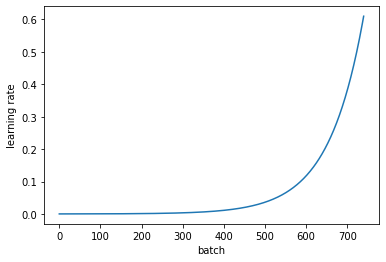

In [8]:
learner.callbacks[2].plot_parameter('learning_rate')

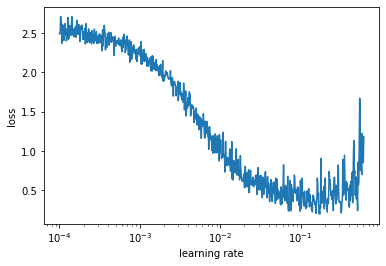

In [9]:
plot_lr_loss(learner.callbacks[2])

In [10]:
best_lr = learner.callbacks[1].best_lr
print(best_lr)

0.1729225624139769


### Train with the found learning rate

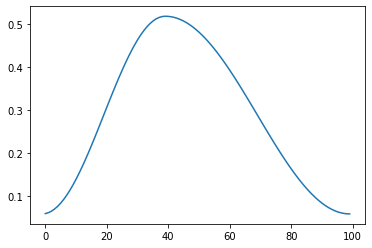

In [11]:
schedule = combine_schedules([0.4, 0.6], one_cycle_cos(best_lr/3, best_lr*3, best_lr/3))

data_bunch = get_data_bunch(*get_mnist_data(), batch_size=64)
model = get_lin_model(data_bunch)
optimizer = DynamicOpt(list(model.parameters()), learning_rate=best_lr)
loss_fn = CrossEntropy()
callbacks = [ParamScheduler('learning_rate', schedule), StatsLogging(), Recorder()]
plot_schedule(schedule)

In [12]:
learner = Learner(data_bunch, model, loss_fn, optimizer, callbacks)
print(learner)

(DataBunch) 
    (DataLoader) 
        (Dataset) x: (50000, 784), y: (50000,)
        (Sampler) total: 50000, batch_size: 64, shuffle: True
    (DataLoader) 
        (Dataset) x: (10000, 784), y: (10000,)
        (Sampler) total: 10000, batch_size: 128, shuffle: False
(Model)
    Linear(784, 50)
    ReLU()
    Linear(50, 10)
(CrossEntropy)
(DynamicOpt) hyper_params: ['learning_rate']
(Callbacks) ['TrainEval', 'ParamScheduler', 'StatsLogging', 'Recorder']


In [13]:
learner.fit(5)

Epoch - 1
train metrics - [0.00021595514297485352, 0.9037]
valid metrics - [1.1210918426513672e-05, 0.9631]

Epoch - 2
train metrics - [1.0733804702758789e-05, 0.9577]
valid metrics - [5.346965789794922e-06, 0.969]

Epoch - 3
train metrics - [4.551753520965576e-05, 0.96702]
valid metrics - [3.795766830444336e-06, 0.9724]

Epoch - 4
train metrics - [8.652238845825196e-05, 0.97188]
valid metrics - [5.627012252807618e-06, 0.9715]

Epoch - 5
train metrics - [8.962793350219727e-06, 0.97494]
valid metrics - [8.443832397460937e-07, 0.9734]

